In [1]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm 
import time
import sys


sys.path.append(os.path.abspath("c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Functions"))
import dppd

In [2]:
import importlib
importlib.reload(dppd)

<module 'dppd' from 'c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Functions\\dppd.py'>

In [3]:
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Classification_Fires')
#fire_data_classified = pd.read_csv('fires_data_classified.geojson', index_col=0)
fire_data_classified = gpd.read_file('fires_data_classified.geojson')
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')
district_boundaries = district_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
mandal_boundaries = gpd.read_file('Mandal_Boundary.shp')
mandal_boundaries = mandal_boundaries.reset_index()

#Create geodataframe from the data
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data['geometry'] = geo_fire_data['geometry'].geometry.to_crs(epsg = 4326)
district_boundaries['geometry'] = district_boundaries['geometry'].geometry.to_crs(epsg = 4326)
mandal_boundaries['geometry'] = mandal_boundaries['geometry'].geometry.to_crs(epsg = 4326)

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month

#Select complete years (2015-2020)
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= '2016-01-01') & (geo_fire_data['acq_date'] < '2019-01-1')]

In [4]:
print('Amount of fires detected: ' + str(len(geo_fire_data)))

Amount of fires detected: 2922


In [5]:
geo_fire_data = geo_fire_data[geo_fire_data['agricultural']==1]
print('Amount of agricultural fires detected: '+ str(len(geo_fire_data)))

Amount of agricultural fires detected: 2922


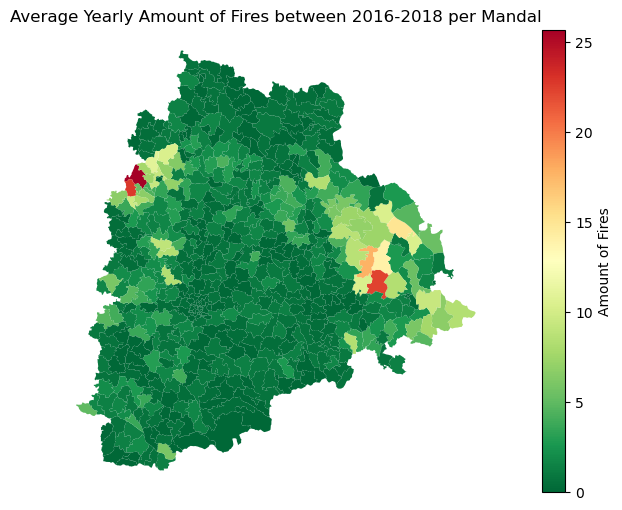

In [6]:
fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])
fires_count['Fire'] = 1

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam', 'year'])['Fire'].sum().unstack(fill_value=0).stack().reset_index()
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])[0].mean().reset_index()

mandal_boundaries = mandal_boundaries.reset_index()
fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry', 'index']], how='left', on=['Dist_Name', 'Mandal_Nam'])

indexes = fires_count['index'].to_list()

for i in range(0, len(mandal_boundaries)):
    if mandal_boundaries['index'].iloc[i] not in indexes:
        data = {'Dist_Name': mandal_boundaries['Dist_Name'].iloc[i], 'Mandal_Nam': mandal_boundaries['Mandal_Nam'].iloc[i], 0 : 0, 'geometry': mandal_boundaries['geometry'].iloc[i], 'index': mandal_boundaries['index'].iloc[i]}
        fires_count = fires_count.append(data, ignore_index=True)


fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 0, legend = True, cmap = 'RdYlGn_r', figsize = (12, 6), legend_kwds = {'label': 'Amount of Fires'}, )
plt.title('Average Yearly Amount of Fires between 2016-2018 per Mandal')
plt.axis('off')
plt.show()

In [7]:
fires_count.sort_values(by=0, ascending = False)

,Dist_Name,Mandal_Nam,0,geometry,index
257,Nizamabad,Bodhan,25.666667,"POLYGON ((77.94774 18.70379, 77.94776 18.70360...",68
264,Nizamabad,Kotagiri,22.666667,"POLYGON ((77.83827 18.62068, 77.83827 18.61972...",255
31,Bhadradri Kothagudem,Yellandu,22.333333,"POLYGON ((80.34248 17.78495, 80.39431 17.74970...",553
140,Mahabubabad,Gangaram,17.666667,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",145
194,Mulugu,Mangapet,15.000000,"POLYGON ((80.50934 18.28808, 80.51119 18.28641...",304
...,...,...,...,...,...
489,Siddipet,Jagdevpur,0.000000,"POLYGON ((78.77908 17.88592, 78.77935 17.88583...",186
490,Kumurambheem Asifabad,Jainoor,0.000000,"POLYGON ((79.00785 19.47145, 79.00864 19.47074...",190
491,Mancherial,Jannaram,0.000000,"POLYGON ((78.97515 19.23802, 78.97540 19.23799...",196
492,Jogulamba Gadwal,Kaloor_Thimmandoddi,0.000000,"POLYGON ((77.49005 16.14921, 77.48982 16.14957...",206


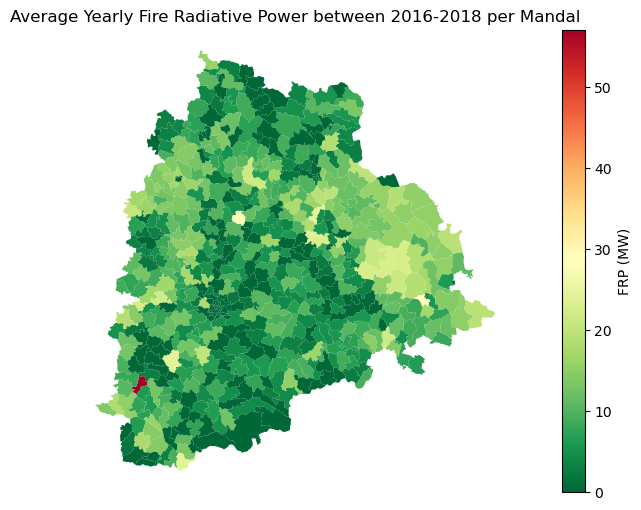

In [8]:
fires = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam', 'year'])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_count = fires_count.groupby(['Dist_Name', 'Mandal_Nam'])[0].mean().reset_index()

fires_count = fires_count.merge(mandal_boundaries[['Dist_Name', 'Mandal_Nam', 'geometry', 'index']], how='left', on=['Dist_Name', 'Mandal_Nam'])

indexes = fires_count['index'].to_list()

for i in range(0, len(mandal_boundaries)):
    if mandal_boundaries['index'].iloc[i] not in indexes:
        data = {'Dist_Name': mandal_boundaries['Dist_Name'].iloc[i], 'Mandal_Nam': mandal_boundaries['Mandal_Nam'].iloc[i], 0 : 0, 'geometry': mandal_boundaries['geometry'].iloc[i], 'index': mandal_boundaries['index'].iloc[i]}
        fires_count = fires_count.append(data, ignore_index=True)

fires_count = gpd.GeoDataFrame(fires_count,geometry = 'geometry', crs = {'init': 'epsg:4326'}) 

fires_count.plot(column = 0, legend = True, cmap = 'RdYlGn_r', figsize = (12, 6), legend_kwds = {'label': 'FRP (MW)'}, )
plt.title('Average Yearly Fire Radiative Power between 2016-2018 per Mandal')
plt.axis('off')
plt.show()

In [9]:
fires_count[0].mean()

7.1625834334756595

In [10]:
fires_count.sort_values(by=0, ascending = False).head(10)
#fires_count[0].mean()

,Dist_Name,Mandal_Nam,0,geometry,index
233,Narayanpet,Dhanwada,57.122222,"POLYGON ((77.69641 16.75135, 77.70094 16.75050...",115
29,Bhadradri Kothagudem,Sujathanagar,29.383333,"POLYGON ((80.60094 17.54757, 80.60099 17.54699...",484
298,Rajanna Sircilla,Mustabad,29.316667,"POLYGON ((78.71965 18.36014, 78.72008 18.36001...",346
99,Karimnagar,Jammikunta,24.716667,"POLYGON ((79.56792 18.41966, 79.56795 18.41963...",194
157,Mahabubnagar,Nawabpet,24.366667,"POLYGON ((78.03417 17.00886, 78.03423 17.00883...",376
67,Jogulamba Gadwal,Alampur,24.288889,"POLYGON ((78.25116 15.97345, 78.25126 15.97295...",10
418,Warangal_Urban,Elkathurthi,23.941667,"POLYGON ((79.41836 18.16764, 79.41854 18.16742...",132
140,Mahabubabad,Gangaram,22.752593,"POLYGON ((80.23231 18.02202, 80.24249 18.01442...",145
381,Vikarabad,Bantwaram,22.650000,"POLYGON ((77.61390 17.44674, 77.61390 17.44685...",43
420,Warangal_Urban,Hasanparthy,22.611111,"POLYGON ((79.58739 18.14184, 79.58763 18.14171...",169


In [11]:
#Select one year
fire_data_2019 = fire_data[fire_data['year']==2019]
fires_agr_2019 = fires[fires['year']==2019]

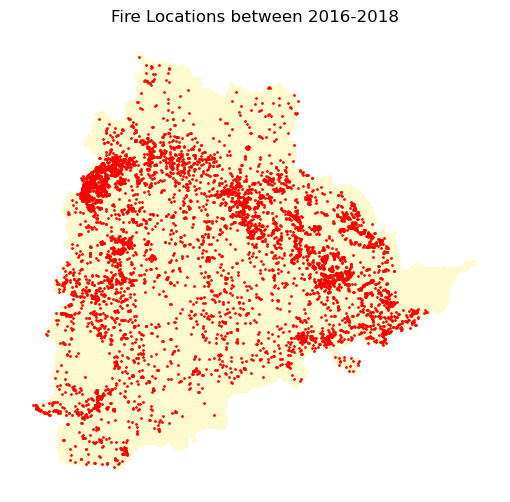

In [12]:
telangana_shape.plot(figsize = (12, 6), color='lemonchiffon')
plt.scatter(fire_data.longitude, fire_data.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Fire Locations between 2016-2018')
plt.axis('off')
plt.show()

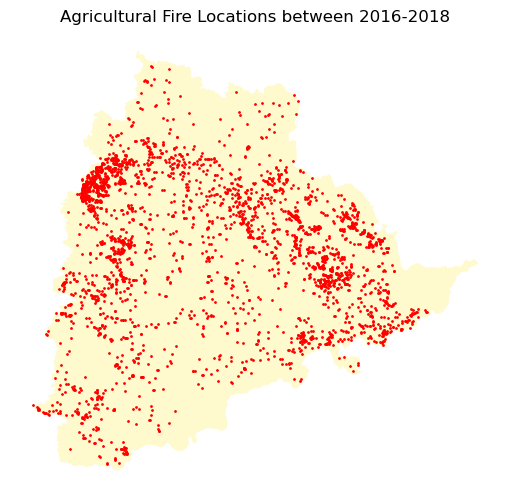

In [13]:
telangana_shape.plot(color = 'lemonchiffon', figsize = (12, 6))
plt.scatter(fires.longitude, fires.latitude, c='red', edgecolor = 'red', s=1)
plt.title('Agricultural Fire Locations between 2016-2018')
plt.axis('off')
plt.show()

In [14]:
geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = fire_data.geometry, crs = {'init': 'epsg:4326'}) 

#Make sure the geometry columns are in the right format
geo_fire_data = geo_fire_data[['geometry', 'acq_date', 'fireID', 'frp']]
geo_fire_data['geometry'] = geo_fire_data['geometry'].to_crs(epsg = 4326)
boundaries = gpd.GeoDataFrame(mandal_boundaries,geometry = mandal_boundaries.geometry, crs = {'init': 'epsg:4326'}) 

#Load date into date format
geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

#Selects the years we are interested in, depending on the input of the function
geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= str(2016)+'-01-01') & (geo_fire_data['acq_date'] < str(2018+1)+'-01-01')]

#Count all fires within a region given by the boundaries dataframe
fires_per_boundaries= gpd.sjoin(geo_fire_data, boundaries, how="inner")

#Create the right time format: We count per month
fires_per_boundaries['day'] = 1 
fires_per_boundaries['year'] = pd.Series(pd.to_numeric(fires_per_boundaries['year'], errors='coerce'), dtype='int64')
fires_per_boundaries['month'] = pd.Series(pd.to_numeric(fires_per_boundaries['month'], errors='coerce'), dtype='int64')
fires_per_boundaries['ModifiedDateTime'] = pd.to_datetime(fires_per_boundaries[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)



unit = 'Number of Fires'
#Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_per_boundaries_count = fires_per_boundaries.groupby(['index', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_boundaries_count['Value'] = fires_per_boundaries_count[0] 

In [15]:
mandal_boundaries[mandal_boundaries['Mandal_Nam'] == 'Yellandu']

,level_0,index,Area,S_No,No_HH,TOT_P,TOT_M,TOT_F,P_06,M_06,...,F_SC,P_ST,M_ST,F_ST,Shape_Leng,Shape_Area,Mandal_Nam,Dist_Name,N_Revenue,geometry
553,553,553,446.0,41.0,24563.0,95394.0,46626.0,48768.0,9227.0,4683.0,...,6329.0,35613.0,17025.0,18588.0,1.166998,44661.83757,Yellandu,Bhadradri Kothagudem,Kothagudem,"POLYGON ((80.34248 17.78495, 80.39431 17.74970..."


In [18]:
import importlib
importlib.reload(dppd)

<module 'dppd' from 'c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Functions\\dppd.py'>

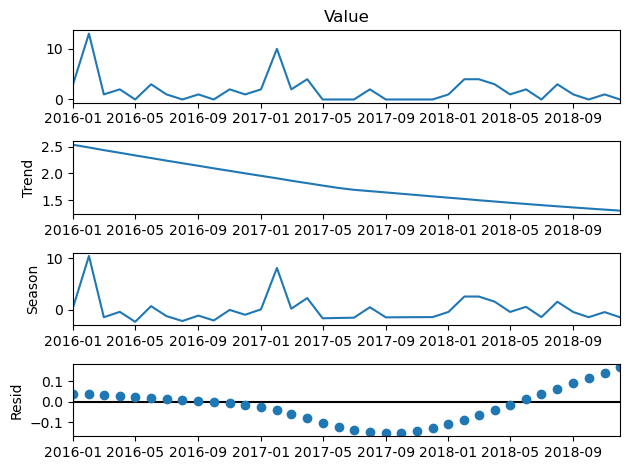

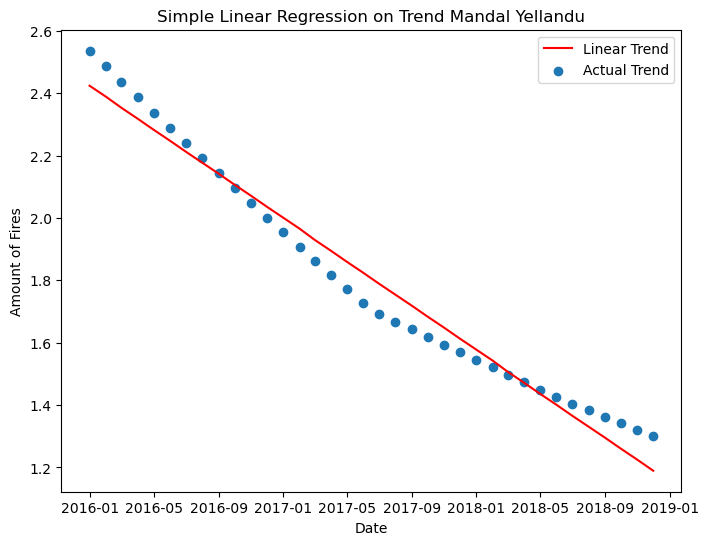

-0.035272500148187044

In [19]:
dppd.Trend_Score(fires_per_boundaries_count, 553, 3)

<ipython-input-24-ca761372d940>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


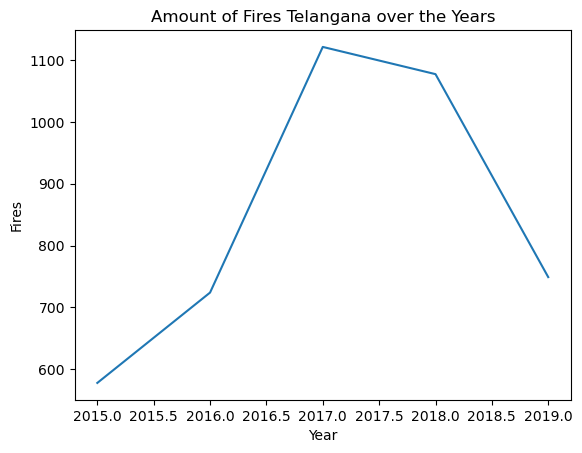

In [24]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['fireID'].count().reset_index()

plt.plot(fires_count['year'], fires_count['fireID'])
plt.title('Amount of Fires Telangana over the Years')
plt.xlabel('Year')
plt.ylabel('Fires')
plt.show()


<ipython-input-26-518709a9020d>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


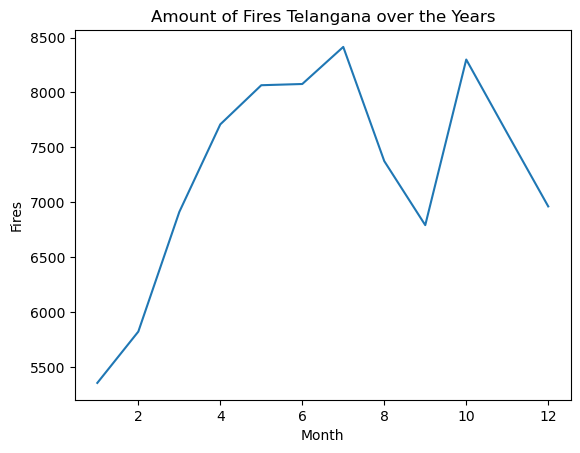

In [26]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['month'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['month'])['fireID'].mean().reset_index()

plt.plot(fires_count['month'], fires_count['fireID'])
plt.title('Amount of Fires Telangana over the Years')
plt.xlabel('Month')
plt.ylabel('Fires')
plt.show()

<ipython-input-4-1a6dc2be2fca>:2: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')


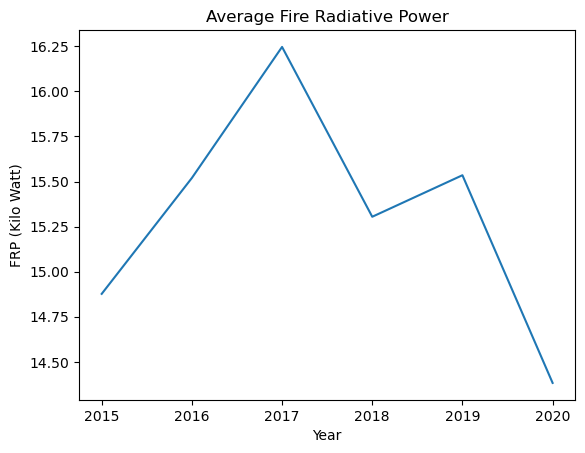

In [4]:
#Create a dataframe that shows the fire location (mandal basis)
fires = gpd.sjoin(geo_fire_data, telangana_shape, how="inner", op='intersects')

#Sort the values based on mandal and time
fires_count = fires.sort_values(by=['year'])

#Sum amount of frp (fire radiative power) per mandal per month per year make sure that if no fire happens at a specific time write a zero
fires_count = fires_count.groupby(['year'])['frp'].mean().reset_index()

plt.plot(fires_count['year'], fires_count['frp'])
plt.title('Average Fire Radiative Power')
plt.xlabel('Year')
plt.ylabel('FRP (Kilo Watt)')
plt.show()

In [20]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['fireID'].count().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Fires'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years')
fig.show()
fig = px.bar(fires_per_mandal_count, x="year", y='Fires', color='Mandal_Nam', title='Amount of Fires per Mandal in Telangana over the Years', barmode='group')
fig.show()
total_fires = fires_per_mandal_count.groupby('Mandal_Nam')['Fires'].sum().reset_index()
total_fires = total_fires.sort_values(by='Fires', ascending = False)
fig = px.bar(total_fires, x='Mandal_Nam', y='Fires', title = 'Total Amount of Fires per Mandal')
fig.show()


<ipython-input-20-511acf62550c>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326




In [6]:
fires_per_mandal = gpd.sjoin(geo_fire_data, mandal_boundaries, how="inner", op='intersects')
fires_per_mandal_count = fires_per_mandal.groupby(['Mandal_Nam', 'year',])['frp'].mean().unstack(fill_value=0).stack().reset_index()
fires_per_mandal_count['Frp (Kilo Watts)'] = fires_per_mandal_count[0]
fig = px.line(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years')
fig.show()

fig = px.bar(fires_per_mandal_count, x="year", y = 'Frp (Kilo Watts)', color='Mandal_Nam', title='Average Fire Radiative Power per Mandal over the Years', barmode='group')
fig.show()

<ipython-input-6-b7e64363caf0>:1: UserWarning:

CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326


